In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd
import pickle
from ananke.graphs import ADMG
from ananke.identification import OneLineID
from ananke.estimation import CausalEffect
from ananke.estimation import AutomatedIF
from causallearn.utils.GraphUtils import GraphUtils
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.collections import PolyCollection
from matplotlib.legend_handler import HandlerTuple
from matplotlib.colors import to_rgb
import seaborn as sns

#### Load CARE model

In [2]:
with open('model/care.model', 'rb') as fp:
    care = pickle.load(fp)      
vertices = care[0]
di_edges = care[1]
bi_edges = care[2]
G = ADMG(vertices, di_edges=di_edges, bi_edges=bi_edges)
# G.draw(direction="LR")

In [4]:
# getting ground truth
df = pd.read_csv('result/Husky_sim.csv')
norm = preprocessing.scale(df.values)
df2 = pd.DataFrame(data=norm, columns=df.columns)
num_config = 18
def get_ground_truth(objective):
    total_ace = []
    Ql = []
    Qu = []
    for config in range(num_config):
        save_stdout = sys.stdout
        sys.stdout = open('trash', 'w')
        ace_obj = CausalEffect(graph=G, treatment=vertices[config], outcome=objective)
        sys.stdout = save_stdout
        ace, ql, qu = ace_obj.compute_effect(df2, "gformula", n_bootstraps=5, alpha=0.05)
        ace = abs(ace)
        Ql.append(ql)
        Qu.append(qu)
        total_ace.append(ace)    
    return sum(total_ace)

GT_ms_ace = get_ground_truth('Mission_success')
GT_energy_ace = get_ground_truth('Battery_percentage')

#### Evaluting Transferability of CARE

In [3]:
def eval_care(num_sample, data, objective, act_ace):
    all_ace = []
    ql = []
    qu = []
    Config = []
    num_config = 18
    norm = preprocessing.scale(data.values)
    df2 = pd.DataFrame(data=norm, columns=data.columns)
    for config in range(num_config):
        save_stdout = sys.stdout
        sys.stdout = open('trash', 'w')
        ace_obj = CausalEffect(graph=G, treatment=vertices[config], outcome=objective)
        sys.stdout = save_stdout
        ace, Ql, Qu = ace_obj.compute_effect(df2, "gformula", n_bootstraps=5, alpha=0.05)
        ace = abs(ace)
        # Ql = abs(Ql)
        # Qu = abs(Qu)
        all_ace.append(ace)
        ql.append(Ql)
        qu.append(Qu)
        Config.append(vertices[config])
    # ACE, CONFIG = zip(*sorted(zip(all_ace,Config), reverse=True))
    pred_ace = sum(all_ace)
    yerr = (sum(qu) - sum(ql)) / num_sample
    rmse = math.sqrt(((act_ace - pred_ace) ** 2) / num_sample)
    
    return rmse, yerr

##### Evaluating transferibility accross platform

In [4]:
## update this values based on the get_ground_truth() function
## fixed to avoid random seed
act_ace_ms = 1.55 # This is the ground truth computed from husky_sim (original causal model)
act_ace_energy = 0.87 # This is the ground truth computed from husky_sim (original causal model)

husky_sim = pd.read_csv('result/Husky_sim.csv')
husky_physical = pd.read_csv('result/Husky_physical.csv')
turtlebot3_physical = pd.read_csv('result/Turtlebot3_physical.csv')

sample_size = range(50, 410, 10)

# Husky
RMSE_ms_sim = []
YERR_ms_sim = []
RMSE_energy_sim = []
YERR_energy_sim = []

# RMSE_ms_real = []
# YERR_ms_real = []
# RMSE_energy_real = []
# YERR_energy_real = []

# Turtlebot
RMSE_ms_real_t = []
YERR_ms_real_t = []
RMSE_energy_real_t = []
YERR_energy_real_t = []

# Husky sim
for i in sample_size:
    rmse, yerr = eval_care(i, data=husky_sim, objective='Mission_success', act_ace=act_ace_ms) 
    RMSE_ms_sim.append(rmse)
    YERR_ms_sim.append(yerr)
for i in sample_size:
    rmse, yerr = eval_care(i, data=husky_sim, objective='Battery_percentage', act_ace=act_ace_energy) 
    RMSE_energy_sim.append(rmse)
    YERR_energy_sim.append(yerr)    
# Husky physical    
# for i in sample_size:
#     rmse, yerr = eval_care(i, data=husky_physical, objective='Mission_success', act_ace=act_ace_ms) 
#     RMSE_ms_real.append(rmse)
#     YERR_ms_real.append(yerr)    
# for i in sample_size:
#     rmse, yerr = eval_care(i, data=husky_physical, objective='Battery_percentage', act_ace=act_ace_energy) 
#     RMSE_energy_real.append(rmse)
#     YERR_energy_real.append(yerr)      
# Turtlebot3 physical    
for i in sample_size:
    rmse, yerr = eval_care(i, data=turtlebot3_physical, objective='Mission_success', act_ace=act_ace_ms) 
    RMSE_ms_real_t.append(rmse)
    YERR_ms_real_t.append(yerr)   
for i in sample_size:
    rmse, yerr = eval_care(i, data=turtlebot3_physical, objective='Battery_percentage', act_ace=act_ace_energy) 
    RMSE_energy_real_t.append(rmse)
    YERR_energy_real_t.append(yerr)          

In [5]:
husky_sim_rmse = [x + y for x, y in zip(RMSE_ms_sim, RMSE_energy_sim)]
husky_sim_yerr = [x + y for x, y in zip(YERR_ms_sim, YERR_energy_sim)]

turtlebot3_phy_rmse = [x + y for x, y in zip(RMSE_ms_real_t, RMSE_energy_real_t)]
turtlebot3_phy_yerr = [x + y for x, y in zip(YERR_ms_real_t, YERR_energy_real_t)]

##### Ploting the results

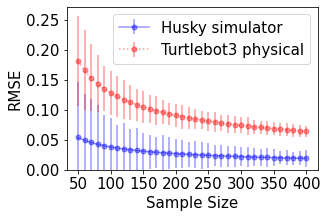

In [8]:
## Mission success
plt.rcParams.update({'figure.figsize':(4.5,3)})
plt.errorbar(sample_size,husky_sim_rmse, yerr=(husky_sim_yerr) , marker='o', markersize=5,
                linestyle='solid', color='b', alpha=0.4, label='Husky simulator')
# plt.errorbar(sample_size,RMSE_ms_real, yerr=(YERR_ms_real) , marker='o', markersize=5,
#                 linestyle='dotted', color='r', alpha=0.6, label='Husky physical')
plt.errorbar(sample_size,turtlebot3_phy_rmse, yerr=(turtlebot3_phy_yerr) , marker='o', markersize=5,
                linestyle='dotted', color='r', alpha=0.4, label='Turtlebot3 physical')

fontsize = 15
labelsize = 15
plt.xlabel('Sample Size', fontsize=fontsize)
plt.ylabel('RMSE', fontsize=fontsize)
plt.xticks(fontsize=labelsize)

plt.yticks(fontsize=labelsize)
plt.legend(fontsize=fontsize) 
# plt.yscale('log')
plt.ylim(ymin=0)
plt.savefig('fig/care_rmse.pdf', dpi=500, bbox_inches='tight')

#### Acc. Pre. Re.

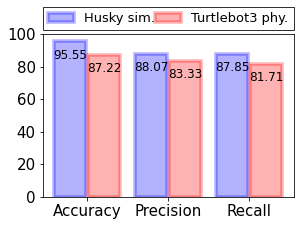

In [140]:
husky_acc = 95.55
husky_pre = 88.07
husky_re = 87.85

t_acc = 87.22
t_pre = 83.33
t_re = 81.71

x = np.arange(3)
husky = [husky_acc, husky_pre, husky_re]
turtlebot3 = [t_acc, t_pre, t_re]

width = 0.4
# plot data in grouped manner of bar type
plt.rcParams.update({'figure.figsize':(4.5,3)})
h = plt.bar(x-0.21, husky, width, label='Husky sim.', edgecolor='b', facecolor= 'b', alpha=0.3, linewidth=3.5)
plt.bar_label(h,  fontsize=12, label_type='edge', padding=-20)
t = plt.bar(x+0.21, turtlebot3, width, label='Turtlebot3 phy.', edgecolor='r', facecolor= 'r', alpha=0.3, linewidth=3.5)
plt.bar_label(t,  fontsize=12, label_type='edge', padding=-20)
plt.xticks(x, ['Accuracy', 'Precision', 'Recall'])

fontsize = 15
labelsize = 15
# plt.xlabel('Sample Size', fontsize=fontsize)
# plt.ylabel('RMSE', fontsize=fontsize)
plt.xticks(fontsize=labelsize)

plt.yticks(fontsize=labelsize)
plt.legend(fontsize=13, bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2, fancybox=False, edgecolor='k') 
plt.savefig('fig/care_acc.pdf', dpi=500, bbox_inches='tight')